In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.optimize import root_scalar

In [24]:
# TEMPLATE CLASS
class ContinuousPokerTemplate:
    @staticmethod
    def value_size(game_params, x):
        raise NotImplementedError("value_size method must be implemented in subclasses")
    
    @staticmethod
    def bluff_size(game_params, x):
        raise NotImplementedError("bluff_size method must be implemented in subclasses")

    @staticmethod
    def call_threshold(game_params, s):
        raise NotImplementedError("call_threshold method must be implemented in subclasses")
    
    @staticmethod
    def bluff_threshold(game_params):
        raise NotImplementedError("bluff_threshold method must be implemented in subclasses")
    
    @staticmethod
    def value_threshold(game_params):
        raise NotImplementedError("value_threshold method must be implemented in subclasses")

    @classmethod
    def payoff_outcome(cls, game_params, x, y):
        if x < cls.bluff_threshold(game_params): # bluff
            s = cls.bluff_size(game_params, x)
            if y < cls.call_threshold(game_params, s):
                return 0.5, "Bluff_Fold"
            else:
                return -s - 0.5, "Bluff_Called"
        elif x > cls.value_threshold(game_params): # value bet
            s = cls.value_size(game_params, x)
            if y < cls.call_threshold(game_params, s):
                return 0.5, "Value_Fold"
            elif y > x:
                return -s - 0.5, "Value_Loses"
            else:
                return s + 0.5, "Value_Wins"
        else: 
            if x > y:
                return 0.5, "Check_Wins" 
            else:
                return -0.5, "Check_Loses"
            
    @classmethod
    def expected_payoff(cls, game_params, grid_size=1001):
        # numerically integrate the payoff(x, y) function over the grid [0,1] x [0,1]
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        payoff_data = np.empty((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, _ = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                except:
                    payoff_data[i, j] = np.nan
        average_payoff = np.nanmean(payoff_data)
        return average_payoff
                
    @classmethod
    def generate_payoff_plot(cls, game_params, grid_size=1001, save_path=None, title="Payoffs by Hand Strength"):
        # ---- Parameters ----
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        X, Y = np.meshgrid(xs, ys, indexing='ij')
        color_cap = 2

        # ---- Compute payoff grid ----
        payoff_data = np.empty((grid_size, grid_size))
        outcome_type = np.empty((grid_size, grid_size), dtype=object)
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, outcome = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                    outcome_type[i, j] = outcome
                except:
                    payoff_data[i, j] = np.nan
        payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

        region_labels = [
            "Bluff_Called", "Bluff_Fold",
            "Value_Wins", "Value_Loses", "Value_Fold",
            "Check_Wins", "Check_Loses"
        ]

        # ---- Plot heatmap with region contours and labels ----
        fig, ax = plt.subplots(figsize=(7, 7))
        c = ax.imshow(
            payoff_clipped.T,
            extent=[0, 1, 0, 1],
            origin='lower',
            cmap='coolwarm',
            norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
        )
        cbar = fig.colorbar(c, ax=ax, shrink=0.9)
        cbar.set_label("Bettor Payoff", fontsize=12)
        cbar.set_ticks([-color_cap, 0, color_cap])
        cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

        for label in region_labels:
            mask = outcome_type == label
            if np.any(mask):
                ax.contour(
                    X, Y, mask.astype(float),
                    levels=[0.5],
                    colors='white',
                    linewidths=1.5
                )
                region_center = np.argwhere(mask)
                if len(region_center) > 0:
                    center_x, center_y = region_center.mean(axis=0)
                    ax.text(
                        xs[int(center_x)], ys[int(center_y)],
                        label.replace("_", " "),
                        color="white",
                        fontsize=10,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
                    )

        ax.set_xlabel("x (bettor hand strength)")
        ax.set_ylabel("y (caller hand strength)")
        ax.set_title(title)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300)
        plt.show()

In [20]:
# FIXED BET CONTINUOUS POKER 

class CP(ContinuousPokerTemplate):
    # ---- Threshold functions ----
       
    def bluff_threshold(game_params):
        B = game_params['B']
        return 2 * B / ((1 + 2 * B) * (4 + 2 * B))

    def value_threshold(game_params):
        B = game_params['B']
        return (2 + 8 * B + 4 * B**2) / ((1 + 2 * B) * (4 + 2 * B))

    def call_threshold(game_params, s):
        return (2 * s * (3 + 2 * s)) / ((1 + 2 * s) * (4 + 2 * s))

    def bluff_size(game_params, x):
        return game_params['B']

    def value_size(game_params, x):
        return game_params['B']

In [ ]:
# NO LIMIT CONTINUOUS POKER
class NLCP(ContinuousPokerTemplate):
    def bluff_threshold(game_params):
        return 1 / 7

    def value_threshold(game_params):
        return 4 / 7

    def call_threshold(game_params, s):
        return 1 - 6 / (7 * (1 + s))

    def bluff_size(game_params, x):
        return (1 / (7 * x)**(1/3)) - 1

    def value_size(game_params, x):
        return np.sqrt(3 / (7 * (1 - x))) - 1

In [54]:
# L, U LIMIT CONTINUOUS POKER

class LULCP_utils:
    _cache = {}

    @staticmethod
    def clear_cache():
        LULCP_utils._cache.clear()

    @staticmethod
    def compute_A0(U):
        if 'A0' not in LULCP_utils._cache:
            LULCP_utils._cache['A0'] = U**2 + 3 * U + 3
        return LULCP_utils._cache['A0']

    @staticmethod
    def compute_A1(U):
        if 'A1' not in LULCP_utils._cache:
            LULCP_utils._cache['A1'] = 7 * U**3 + 21 * U**2 + 21 * U + 6
        return LULCP_utils._cache['A1']

    @staticmethod
    def compute_A2(U):
        if 'A2' not in LULCP_utils._cache:
            LULCP_utils._cache['A2'] = 6 * U**3 + 18 * U**2 + 18 * U + 5
        return LULCP_utils._cache['A2']

    @staticmethod
    def compute_A3(U):
        if 'A3' not in LULCP_utils._cache:
            LULCP_utils._cache['A3'] = 7 * U**3 + 21 * U**2 + 18 * U + 3
        return LULCP_utils._cache['A3']

    @staticmethod
    def compute_A4(L, U):
        if 'A4' not in LULCP_utils._cache:
            A1 = LULCP_utils.compute_A1(U)
            A2 = LULCP_utils.compute_A2(U)
            LULCP_utils._cache['A4'] = 3 * A1 * L**2 + 3 * A1 * L + A1 + A2 * L**3
        return LULCP_utils._cache['A4']

    @staticmethod
    def compute_A5(L, U):
        if 'A5' not in LULCP_utils._cache:
            A0 = LULCP_utils.compute_A0(U)
            LULCP_utils._cache['A5'] = 3 * A0 * L**2 * U + 3 * A0 * L * U + A0 * U - L**3
        return LULCP_utils._cache['A5']

    @staticmethod
    def compute_x0(L, U):
        if 'x0' not in LULCP_utils._cache:
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x0'] = (3 * (L + 1)**3 * U) / A4
        return LULCP_utils._cache['x0']

    @staticmethod
    def compute_x1(L, U):
        if 'x1' not in LULCP_utils._cache:
            A0 = LULCP_utils.compute_A0(U)
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x1'] = (3 * A0 * L * U + A0 * U - L**3 - 3 * L**2) / A4
        return LULCP_utils._cache['x1']

    @staticmethod
    def compute_x2(L, U):
        if 'x2' not in LULCP_utils._cache:
            A5 = LULCP_utils.compute_A5(L, U)
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x2'] = A5 / A4
        return LULCP_utils._cache['x2']

    @staticmethod
    def compute_x3(L, U):
        if 'x3' not in LULCP_utils._cache:
            A2 = LULCP_utils.compute_A2(U)
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x3'] = (A2 * L**3 + 3 * A2 * L**2 + 3 * L * (5 * U**3 + 15 * U**2 + 15 * U + 4) +
                                        4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LULCP_utils._cache['x3']

    @staticmethod
    def compute_x4(L, U):
        if 'x4' not in LULCP_utils._cache:
            A1 = LULCP_utils.compute_A1(U)
            A2 = LULCP_utils.compute_A2(U)
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x4'] = (3 * A1 * L**2 + A2 * L**3 + 3 * A2 * L + 4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LULCP_utils._cache['x4']

    @staticmethod
    def compute_x5(L, U):
        if 'x5' not in LULCP_utils._cache:
            A3 = LULCP_utils.compute_A3(U)
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['x5'] = (3 * A3 * L**2 + 3 * A3 * L + A3 + L**3 * (6 * U**3 + 18 * U**2 + 15 * U + 2)) / A4
        return LULCP_utils._cache['x5']

    @staticmethod
    def compute_b0(L, U):
        if 'b0' not in LULCP_utils._cache:
            A4 = LULCP_utils.compute_A4(L, U)
            LULCP_utils._cache['b0'] = -(L + 1)**3 / A4
        return LULCP_utils._cache['b0']
    
    @staticmethod
    def v_of_s(s, x2):
        return (x2 + 2*s**2 + 4*s + 1)/(2*(1 + s)**2)
    
    @staticmethod
    def b_of_s(s, b0, x2):
        return b0 - ((1 + 3*s)*(x2 - 1)) / (6*(1 + s)**3)



class LULCP(ContinuousPokerTemplate):
    @staticmethod
    def inverse_b(x, b0, x2, bracket=(1e-6, 100)):
        # Solve b(s) = x for s
        f = lambda s: LULCP_utils.b_of_s(s, b0, x2) - x
        sol = root_scalar(f, bracket=bracket, method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Root finding did not converge")

    @staticmethod
    def inverse_v(x, x2, bracket=(1e-6, 100)):
        # Solve v(s) = x for s
        f = lambda s: LULCP_utils.v_of_s(s, x2) - x
        sol = root_scalar(f, bracket=bracket, method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Root finding did not converge")

    def call_threshold(game_params, s):
        x2 = LULCP_utils.compute_x2(game_params['L'], game_params['U'])
        return (x2+s)/(1+s)
    
    def bluff_threshold(game_params):
        return LULCP_utils.compute_x2(game_params['L'], game_params['U'])
    
    def value_threshold(game_params):
        return LULCP_utils.compute_x3(game_params['L'], game_params['U'])
    
    def bluff_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x0 = LULCP_utils.compute_x0(L, U)
        x1 = LULCP_utils.compute_x1(L, U)
        x2 = LULCP_utils.compute_x2(L, U)
        b0 = LULCP_utils.compute_b0(L, U)
        if x < x0:
            return L
        elif x < x1:
            return LULCP.inverse_b(x, b0, x2)
        else:
            return U
        
    def value_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x2 = LULCP_utils.compute_x2(L, U)
        x4 = LULCP_utils.compute_x4(L, U)
        x5 = LULCP_utils.compute_x5(L, U)
        if x < x4:
            return L
        elif x < x5:
            return LULCP.inverse_v(x, x2)
        else:
            return U

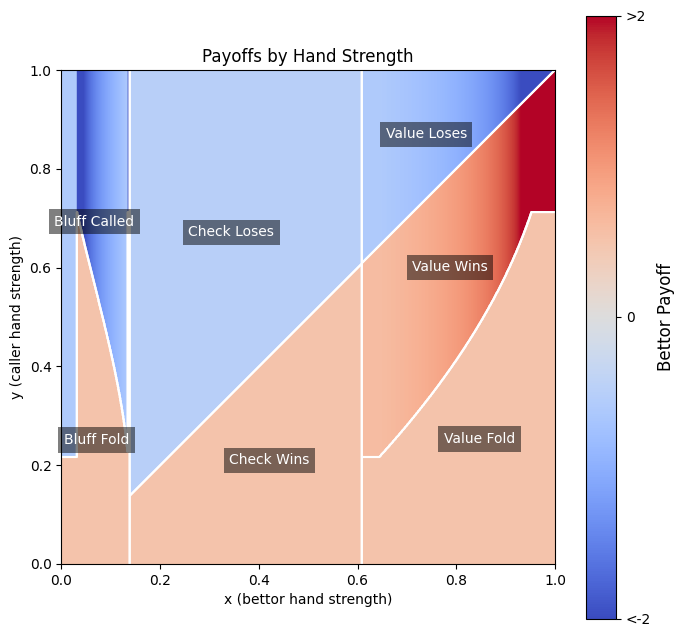

In [56]:
LULCP_utils.clear_cache()
params = {"L": 0.1, "U": 2}

# LULCP.value_size(params, 0.9)
# LULCP.bluff_size(params, 0.05)
# LULCP.call_threshold(params, 1)

# LULCP.payoff_outcome({"L": 0.1, "U": 2}, 0.5, 0.5) 
LULCP.generate_payoff_plot({"L": 0.1, "U": 2})

In [ ]:
# EXPECTED PAYOFF OVER L, U GRID



# print(expected_payoff(lambda x, y: payoff_outcome_LU(x, y, 1, 1)))
# print(expected_payoff(payoff_NoLimit))
print(expected_payoff(lambda x, y: payoff(1,), 11))

    


nan


/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_7388/1394443586.py:16: RuntimeWarning: Mean of empty slice
  average_payoff = np.nanmean(payoff_data)
